(1.068+/-0.013)e+05


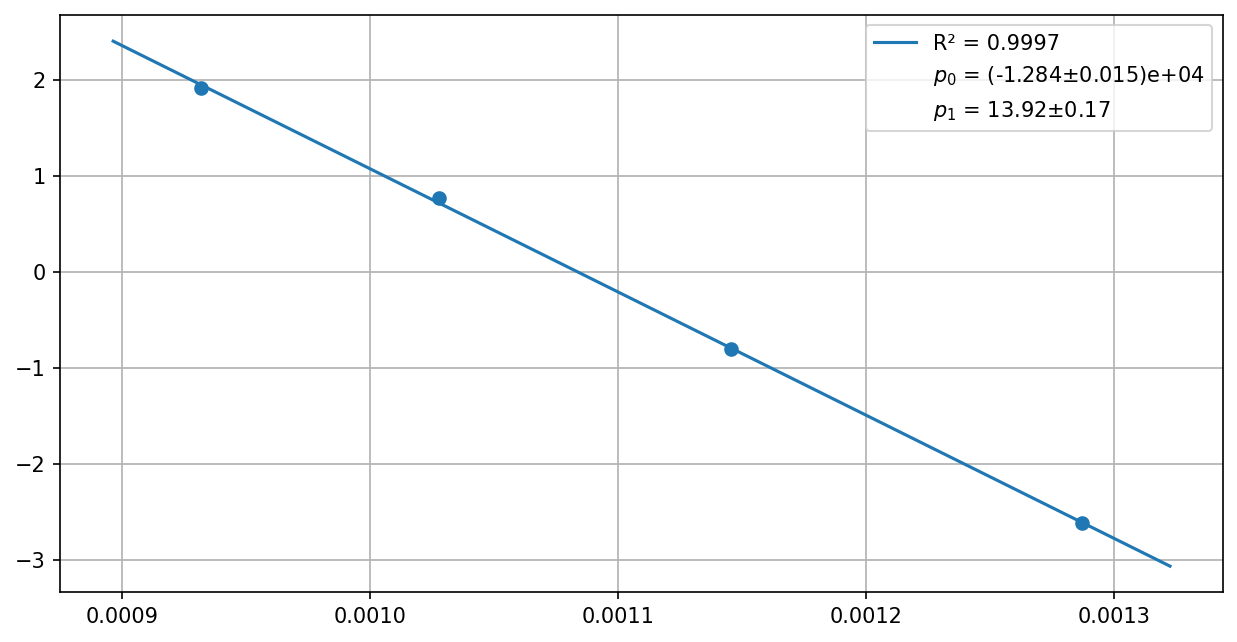

In [2]:
from unc_tools import UncRegression
import numpy as np

x = [777,873,973,1073,1173,1273,1373]
y = [0.073, 0.447, 2.15, 6.81, 13.7, 19.49, 23.4]

x = np.array(x)
y = np.array(y)

a = slice(0,-3)
x = x[a]
y = y[a]

reg = UncRegression(1/x,np.log(y))
reg.plot()
print(-reg.coefs[0]*8.314)

In [31]:
import re
from collections import defaultdict, OrderedDict
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def parse_reaction_string(rxn_str):
    """
    Возвращает tuple:
      (reactants_dict, products_dict, params_dict, reversible_bool)
    reactants/products: {species: stoich}
    params_dict: {'kf': float, 'kr': float_or_None}
    """
    # разделяем на часть с уравнением и часть с параметрами (через запятую, но параметров может быть несколько)
    parts = rxn_str.split(',')
    eq_part = parts[0].strip()
    params_part = ','.join(parts[1:]) if len(parts) > 1 else ''

    # ищем стрелку (поддерживаем -> и <-> и <-)
    m = re.search(r'(<->|->|<-)', eq_part)
    if not m:
        raise ValueError(f"No arrow found in reaction: {rxn_str}")
    arrow = m.group(1)
    reversible = (arrow == '<->')

    left, right = [s.strip() for s in re.split(r'(<->|->|<-)', eq_part) if s.strip() and s.strip() != arrow]
    # парсер одного блока (например "4NO + 3O2")
    def parse_block(block):
        res = defaultdict(int)
        for token in re.split(r'\+', block):
            token = token.strip()
            if not token:
                continue
            # разрешаем дробные коэфы, но конвертируем в float -> если целое, до int
            m2 = re.match(r'^(\d*\.?\d*)\s*([A-Za-z0-9_()]+)$', token)
            if not m2:
                raise ValueError(f"Can't parse token '{token}' in '{block}'")
            sto = m2.group(1)
            name = m2.group(2)
            sto = float(sto) if sto != '' else 1.0
            # если целое — сохранить как int для аккуратности
            if abs(sto - round(sto)) < 1e-12:
                sto = int(round(sto))
            res[name] += sto
        return dict(res)

    reactants = parse_block(left)
    products = parse_block(right)

    # парсим параметры k, kf, kr
    params = {}
    # ищем kf=..., kr=..., k=...
    for key in ('kf', 'kr', 'k'):
        m3 = re.search(rf'{key}\s*=\s*([0-9]*\.?[0-9]+)', params_part)
        if m3:
            params[key] = float(m3.group(1))

    # нормализуем: если указан k и не указан kf -> ставим kf=k
    if 'k' in params and 'kf' not in params:
        params['kf'] = params['k']

    # если обратимая реакция, желательно иметь и kr (если нет — kr=0)
    if reversible and 'kr' not in params:
        params['kr'] = 0.0

    # для необратимой: kf либо задан либо 1.0 по умолчанию
    if not reversible and 'kf' not in params:
        params['kf'] = params.get('k', 1.0)

    return reactants, products, {'kf': params.get('kf', 0.0), 'kr': params.get('kr', None)}, reversible


def solve_kinetics_numeric(reactions, x0_dict=None, t_span=(0,10), t_eval=None):
    """
    reactions: список строк, например ["4NO + 3O2 -> 2N2O5, k=0.1", "C -> D + E, kf=0.2, kr=0.05"]
    x0_dict: начальные концентрации {species: value}. Отсутствующие виды будут считаться 0.
    Возвращает: (species_list, t_array, y_array) где y_array.shape = (n_species, len(t_array))
    """
    if x0_dict is None:
        x0_dict = {}

    parsed = []
    species_order = OrderedDict()

    # парсим
    for rxn in reactions:
        rcts, prods, params, rev = parse_reaction_string(rxn)
        parsed.append((rcts, prods, params, rev))
        for s in list(rcts.keys()) + list(prods.keys()):
            species_order.setdefault(s, None)

    species = list(species_order.keys())
    idx = {s:i for i,s in enumerate(species)}

    # ODE
    def odes(t, y):
        dydt = np.zeros_like(y, dtype=float)
        for rcts, prods, params, rev in parsed:
            # скорость прямого направления
            rate_f = params.get('kf', 0.0)
            for sp, st in rcts.items():
                rate_f *= y[idx[sp]]**st
            rate_b = 0.0
            if rev and params.get('kr') is not None:
                rate_b = params['kr']
                for sp, st in prods.items():
                    rate_b *= y[idx[sp]]**st
            net = rate_f - rate_b
            # применяем стехиометрию
            for sp, st in prods.items():
                dydt[idx[sp]] += st * net
            for sp, st in rcts.items():
                dydt[idx[sp]] -= st * net
        return dydt

    # начальные условия (отсутствующие — 0)
    y0 = np.array([float(x0_dict.get(s, 0.0)) for s in species], dtype=float)

    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 200)

    sol = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45', atol=1e-8, rtol=1e-6)
    if not sol.success:
        raise RuntimeError("ODE solver failed: " + (sol.message or "unknown"))

    return species, sol.t, sol.y


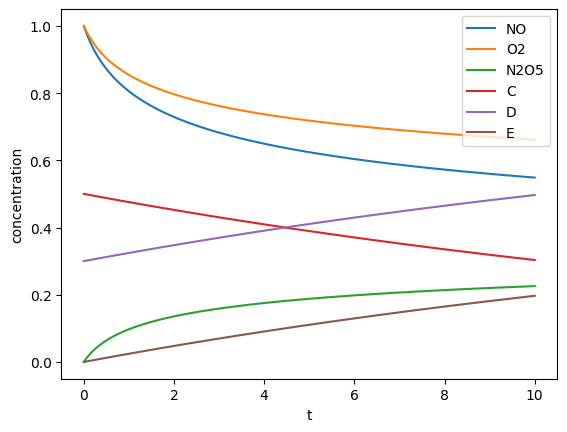

In [30]:
import matplotlib.pyplot as plt

reactions = [
    "4NO + 3O2 -> 2N2O5, k=0.1",
    "C -> D + E, k=0.05"
]

x0 = {
    "NO": 1.0,
    "O2": 1.0,
    "N2O5": 0.0,
    "C": 0.5,
    "D": 0.3,
    "E": 0.0
}

species, t, y = solve_kinetics_numeric(reactions, x0)

for i, s in enumerate(species):
    plt.plot(t, y[i], label=s)

plt.legend()
plt.xlabel("t")
plt.ylabel("concentration")
plt.show()
